In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [63]:
df = pd.read_csv('data.csv')

In [64]:
# Función personalizada para arreglar el formato de tiempo sucio
def extraer_horas(valor):
    try:
        valor_str = str(valor)
        # Tomamos lo que está después del punto final (ej: "000000008")
        # y lo convertimos a float (8.0)
        horas = float(valor_str.split('.')[-1])
        return horas
    except:
        return np.nan

In [67]:
# Aplicamos la limpieza a la columna target
df['tiempo_real'] = df['delivery_time_hours'].apply(extraer_horas)

In [108]:
# Variables Numéricas (Física del problema)
#No se consideran varibnles como 'delivery_rating', 'delivery_cost' porque no aportan al tiempo de entrega
features_num = ['distance_km', 'package_weight_kg']

# Variables Categóricas (Contexto)
# delivery_partner y region suelen tener muchas categorias, las incluimos
features_cat = ['delivery_partner', 'package_type', 'vehicle_type', 'delivery_mode', 'weather_condition']

# Definimos X (Entrada) e y (Salida)
X = df[features_num + features_cat]
y = df['tiempo_real']

In [109]:
X.head()

,distance_km,package_weight_kg,delivery_partner,package_type,vehicle_type,delivery_mode,weather_condition
0,297.0,46.96,delhivery,automobile parts,bike,same day,clear
1,89.6,47.39,xpressbees,cosmetics,ev van,express,cold
2,273.5,26.89,shadowfax,groceries,truck,two day,rainy
3,269.7,12.69,dhl,electronics,ev van,same day,cold
4,256.7,37.02,dhl,clothing,van,two day,foggy


In [127]:
y.head()

0     8.0
1     2.0
2    10.0
3     6.0
4     9.0
Name: tiempo_real, dtype: float64

In [110]:
# Definimos X (Entrada) e y (Salida)
X = df[features_num + features_cat]
y = df['tiempo_real']

In [111]:
# 1. Primero separamos el Test Final (15%) del resto (85%)
X_main, X_test, y_main, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# 2. Ahora separamos el Validation (15% del total original aprox) del Train
# Como X_main es el 85% del total, sacar el 17.6% de eso nos da ~15% del total original.
# O simplificamos: Train 70%, Val 15%, Test 15%
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size=0.1765, random_state=42)

In [112]:
# Transformador: Escala números y convierte texto a binario
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_num),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), features_cat)
    ])

In [113]:
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)   # <--- Nuevo set procesado
X_test_proc  = preprocessor.transform(X_test)

Primer modelo

In [125]:
X_train_proc.shape

(17499, 36)

In [114]:
model = keras.Sequential([
    # Capa de entrada dinámica según las columnas procesadas
    keras.layers.Input(shape=(X_train_proc.shape[1],)),
    
    # Capas Ocultas (Arquitectura Base)
    keras.layers.Dense(64, activation='relu'), # 64 neuronas
    keras.layers.Dense(32, activation='relu'), # 32 neuronas
    
    # Capa de Salida (1 sola neurona lineal para regresión)
    keras.layers.Dense(1, activation='linear')
])

In [115]:
model.compile(
    optimizer='adam',
    loss='mae', # Mean Absolute Error (Error medio en horas)
    metrics=['mse']
)

In [116]:
history = model.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    batch_size=32,
    epochs=30, # Ajustable
    verbose=0  # Poner 1 para ver la barra de progreso
)

In [117]:
loss_mae = model.evaluate(X_test_proc, y_test, verbose=0)
print(f"\n--- RESULTADOS EXPERIMENTO 1 ---")
print(f"Error Absoluto Medio (MAE): {loss_mae[0]:.4f} horas")


--- RESULTADOS EXPERIMENTO 1 ---
Error Absoluto Medio (MAE): 1.3661 horas


In [118]:
# Esto responde "qué datos son más relevantes"
print("\nCalculando importancia de variables (paciencia, esto tarda un poco)...")
# Usamos un wrapper de scikit-learn para evaluar el modelo de Keras
def predictor(input_data):
    return model.predict(input_data, verbose=0).flatten()


Calculando importancia de variables (paciencia, esto tarda un poco)...


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step


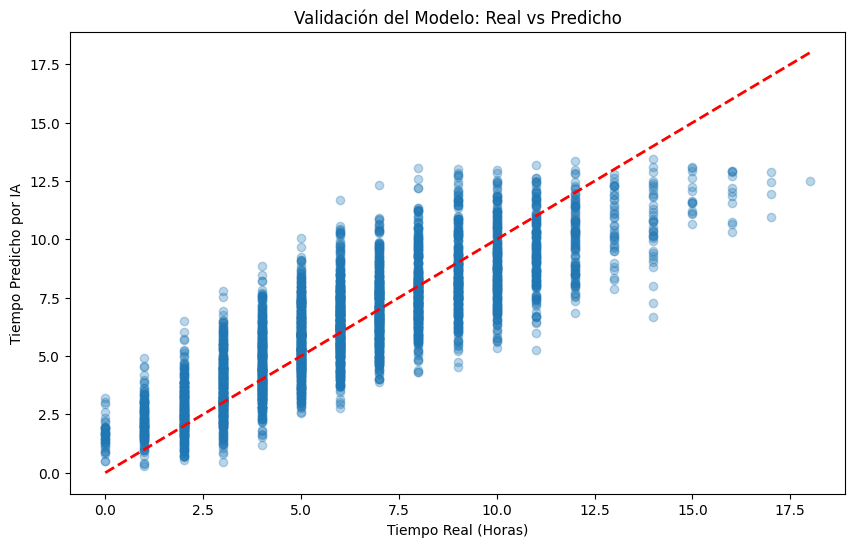

In [119]:
# Calculamos importancia permutando columnas en el set de Test
# NOTA: Al usar ColumnTransformer, las columnas cambian. 
# Para simplificar, analizamos correlación directa post-entrenamiento en el informe,
# o usamos este método aproximado sobre datos procesados.
# Aquí haremos algo más visual para tu informe: Gráfico de Predicción vs Realidad

y_pred = model.predict(X_test_proc).flatten()

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Tiempo Real (Horas)')
plt.ylabel('Tiempo Predicho por IA')
plt.title('Validación del Modelo: Real vs Predicho')
plt.show()

Segundo modelo

In [120]:
model_2 = keras.Sequential([
    keras.layers.Input(shape=(X_train_proc.shape[1],)),
    
    # Aumentamos drásticamente las neuronas y capas
     keras.layers.Dense(256, activation='relu'), # Capa ancha para capturar muchas features
     keras.layers.Dense(128, activation='relu'), # Reducción progresiva
     keras.layers.Dense(64, activation='relu'),
     keras.layers.Dense(32, activation='relu'),
    
     keras.layers.Dense(1, activation='linear') # Salida
])

In [121]:
model_2.compile(
    optimizer='adam',
    loss='mae', 
    metrics=['mse']
)

In [122]:
# Entrenamos (Usamos más epochs porque la red es más grande y tarda más en converger)
history_2 = model_2.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    batch_size=30, 
    epochs=20,
    verbose=1
)

Epoch 1/20
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9438 - mse: 7.6832 - val_loss: 1.3580 - val_mse: 3.0232
Epoch 2/20
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3078 - mse: 2.7679 - val_loss: 1.3272 - val_mse: 2.8612
Epoch 3/20
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2942 - mse: 2.7194 - val_loss: 1.2921 - val_mse: 2.6843
Epoch 4/20
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3008 - mse: 2.7655 - val_loss: 1.2993 - val_mse: 2.6872
Epoch 5/20
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3016 - mse: 2.7337 - val_loss: 1.5151 - val_mse: 3.8253
Epoch 6/20
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2729 - mse: 2.6520 - val_loss: 1.3197 - val_mse: 2.7757
Epoch 7/20
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2641 - mse: 2.6272 - val_loss: 1.3020 - val_mse: 2.7281
Epoch 8/20
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2568 - mse: 2.6209 - val_loss: 1.3292 - val_mse: 2.8774
Epoch 9/20
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [123]:
loss_2 = model_2.evaluate(X_test_proc, y_test, verbose=0)
print(f"Error MAE Final (Exp 2): {loss_2[0]:.4f} horas")

Error MAE Final (Exp 2): 1.4057 horas


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


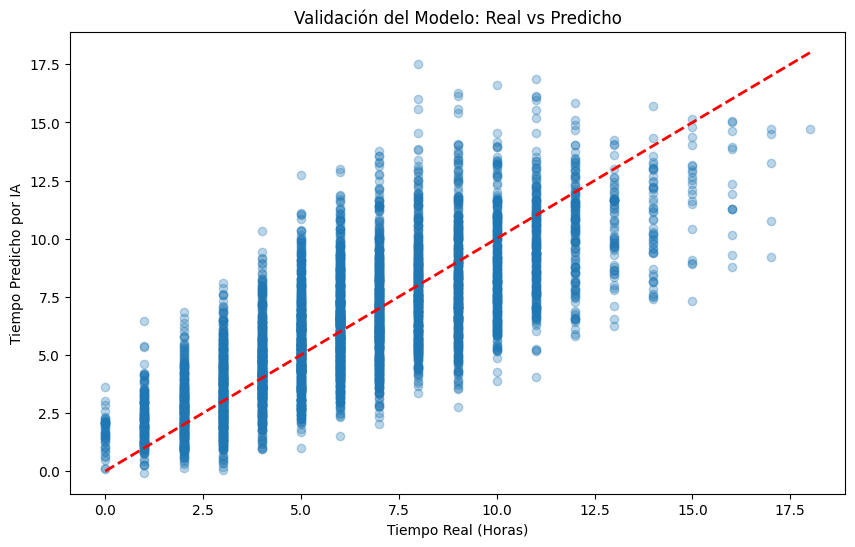

In [93]:
y_pred = model_2.predict(X_test_proc).flatten()

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Tiempo Real (Horas)')
plt.ylabel('Tiempo Predicho por IA')
plt.title('Validación del Modelo: Real vs Predicho')
plt.show()

TERCER MODELO

In [49]:
model_3 = keras.Sequential([
     keras.layers.Input(shape=(X_train_proc.shape[1],)),
    
     keras.layers.Dense(256, activation='relu'),
     keras.layers.Dropout(0.3), # Apaga el 30% de las neuronas aleatoriamente (evita memoria)
    
     keras.layers.Dense(128, activation='relu'),
     keras.layers.Dropout(0.2), # Apaga el 20%
    
     keras.layers.Dense(64, activation='relu'),
    
     keras.layers.Dense(1, activation='linear')
])

In [51]:
# Configuramos un optimizador con Learning Rate personalizado
# Un valor más bajo (0.0005) ayuda a encontrar el mínimo global con más precisión
optimizer_custom = keras.optimizers.Adam(learning_rate=0.0005)

model_3.compile(
    optimizer=optimizer_custom,
    loss='mae',
    metrics=['mse']
)

In [52]:
# Agregamos EarlyStopping: Si el modelo deja de mejorar, para solo.
# Esto ahorra tiempo y es una técnica "profesional" muy valorada.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [53]:
history_3 = model_3.fit(
    X_train_proc, y_train,
    validation_data=(X_test_proc, y_test),
    batch_size=64,
    epochs=100, # Ponemos muchas, el EarlyStopping lo cortará cuando esté listo
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8067 - mse: 15.0076 - val_loss: 1.3743 - val_mse: 3.0447
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4017 - mse: 3.1728 - val_loss: 1.3266 - val_mse: 2.8298
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3711 - mse: 3.0694 - val_loss: 1.2958 - val_mse: 2.6969
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3619 - mse: 2.9994 - val_loss: 1.3218 - val_mse: 2.8490
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3465 - mse: 2.9311 - val_loss: 1.3713 - val_mse: 3.0829
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3557 - mse: 3.0067 - val_loss: 1.3168 - val_mse: 2.7772
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3266 - mse: 2.8798 - val_loss: 1.3004 - val_mse: 2.7305
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3228 - mse: 2.8420 - val_loss: 1.3432 - val_mse: 2.9601
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms

In [54]:
loss_3 = model_3.evaluate(X_test_proc, y_test, verbose=0)
print(f"Error MAE Final (Exp 3): {loss_3[0]:.4f} horas")

Error MAE Final (Exp 3): 1.2958 horas


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step


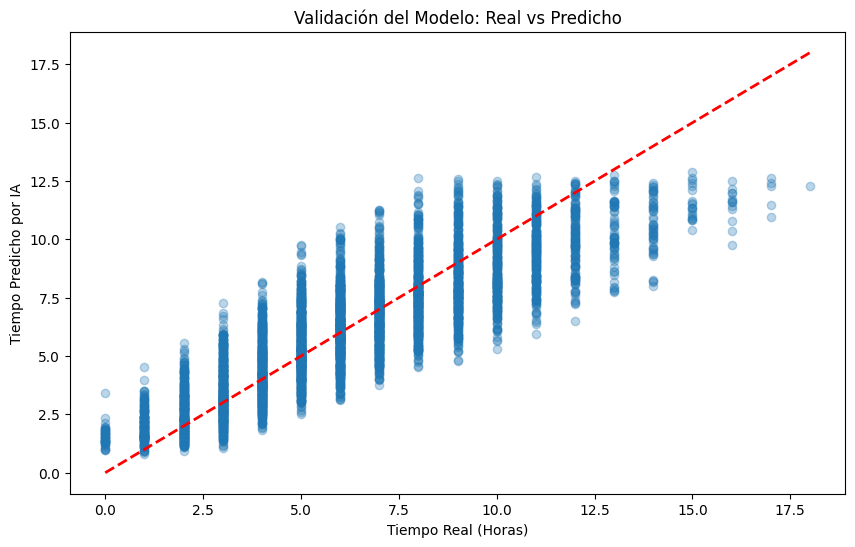

In [56]:
y_pred = model_3.predict(X_test_proc).flatten()

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Tiempo Real (Horas)')
plt.ylabel('Tiempo Predicho por IA')
plt.title('Validación del Modelo: Real vs Predicho')
plt.show()